<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/33_Ultra_Lite_%D0%90%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA%D0%B8_(%D0%A3%D0%BD%D0%B8%D0%B2%D0%B5%D1%80%D1%81%D0%B8%D1%82%D0%B5%D1%82_%D0%B8%D1%81%D0%BA%D1%83%D1%81%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE_%D0%B8%D0%BD%D1%82%D0%B5%D0%BB%D0%BB%D0%B5%D0%BA%D1%82%D0%B0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Ultra Lite

Макс 10 баллов

Перепишите автокодировщик Mnist “с нуля”  в новом ноутбуке. Можно подсматривать в ноутбук занятия, но крайне желательно писать код своими руками, а не копировать.

# Автокодировщик

In [ ]:
from tensorflow.keras.models import Model, Sequential # Загружаем абстрактный класс базовой модели сети от кераса и последовательную модель
# Слои для нейросети
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization  
from tensorflow.keras import backend as K # подтягиваем базовые керасовские функции
from tensorflow.keras.optimizers import Adam # Загружаем оптимизатор
from tensorflow.keras import utils # утилиты кераса
from tensorflow.keras.datasets import mnist, fashion_mnist # загружаем отовые базы 
from tensorflow.keras.callbacks import LambdaCallback # загружаем коллбек (его сами будем писать)

import matplotlib.pyplot as plt # возьмем интерфейс для построения графиков простых функций
from tensorflow.keras.preprocessing import image # модуль для отрисовки изображений
import numpy as np
import pandas as pd
from PIL import Image # модуль для отрисовки изображений
from sklearn.model_selection import train_test_split # модуль для разбивки выборки на тренировочную и тестовую
from sklearn.preprocessing import StandardScaler # модуль для нормализации данных

import os  
from google.colab import drive # модуль для работы с google disk
import time, random
import seaborn as sns
sns.set_style('darkgrid')


In [ ]:
drive.mount('/content/drive/') # монтируем google диск

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Создаем функцию автокодировщика
def baseAutoencoder(shape=(112, 80, 1)):
  img_input = Input((shape)) # задаем входные размеры

  x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input) #входные данные передаем на слой двумерной свертки
  x = BatchNormalization()(x)
  x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D()(x)  # передаем на слой подвыборки, снижающей размерность поступивших на него данных
   
  x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  z = MaxPooling2D()(x) # передае на слой подвыборки

  x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(z) 
  x = BatchNormalization()(x)
  
  x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)  
  x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)  
  x = BatchNormalization()(x)  
  x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)  
  x = BatchNormalization()(x)  

  # Финальный слой двумерной свертки, выдающий итоговое изображение
  x = Conv2D(shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

  model = Model(img_input, x) # указываем модель, с оригинальным изображением на входе в сеть и сжатым-разжатым на выходе из сети
  model.compile(optimizer=Adam(lr=0.0001),
                loss='mean_squared_error') # компилируем модель с оптимайзером Адам и среднеквадратичной ошибкой

  return model # функция вернёт заданную модель

  

In [ ]:
# Создадим функцию для вывода изображений как картинок
def plotImages(xTrain, pred, shape=(112,80)):
  n=5 # кол-во картинок к показу
  plt.figure(figsize=(14, 7)) # указываем размеры фигуры
  for i in range(n): # для каждой картинки из 5ти
    index = np.random.randint(0, pred.shape[0]) # startIndex = начиная с какого индекса хотим заплотить картинки
    # Показываем картинки из тестового набора
    ax = plt.subplot(2, n, i+1) #выведем область рисования Axes
    plt.imshow(xTrain[index].reshape(shape)) 
    plt.gray() # выведем в черно-белом цвете
    # Cкрываем вывод координтной оси Х и Y
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Показываем восстановленные картинки
    ax = plt.subplot(2, n, i+1+n) # выведем область рисования Axes 
    plt.imshow(pred[index].reshape(shape)) # отрисуем обработанные сеткой картинки в размере 112*80     
    plt.gray() # выведем в черно-белом цвете
    # Cкрываем вывод координтной оси Х и Y
    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False) 
  plt.show()  


In [ ]:
# Функция для расчета mse
def getMSE(x1, x2):
  x1 = x1.flatten() # сплющиваем в одномерный вектор
  X2 = x2.flatten() # cплющиваем в одномерный вектор
  delta = x1-x2 # находим разницу
  return sum(delta**2)/len(delta) # и возвращаем сумму квадратов разницы, деленную на длину разницы

  

In [ ]:
# Зададим пару массивов и проверим работу функции

x1 = np.array([1,1,1]) # 1й массив
x2 = np.array([1,1,1]) # 2й массив
print(getMSE(x1,x2))

0.0


In [ ]:
# Зададим пару массивов и проверим работу функции

x1 = np.array([1,1,1,1]) # 1й массив
x2 = np.array([1,1,0,0]) # 2й массив
print(getMSE(x1,x2))

0.5


# MNIST

In [ ]:
(xTrainMnist, yTrainMnist), (xTestMnist, yTestMnist) = mnist.load_data() # загружаем данные из базы с разбивкой на train/test
xTrainMnist = xTrainMnist.astype('float32')/255 # представляем в виде значений от 0 до 1
xTrainMnist = xTrainMnist.reshape(-1, 28, 28, 1) # меняем форму, приводим к нужным нам размерам
xTestMnist = xTestMnist.astype('float32')/255 # на тесте делаем тоже самое 
xTestMnist = xTestMnist.reshape(-1, 28, 28, 1) # на тесте делаем тоже самое 


11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# Посмотрим размер xTrainMnist
xTrainMnist.shape

(60000, 28, 28, 1)

In [ ]:
# Создаем автокодировщик
modelAutoMnist = baseAutoencoder((28,28,1)) 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
modelAutoMnist.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0     

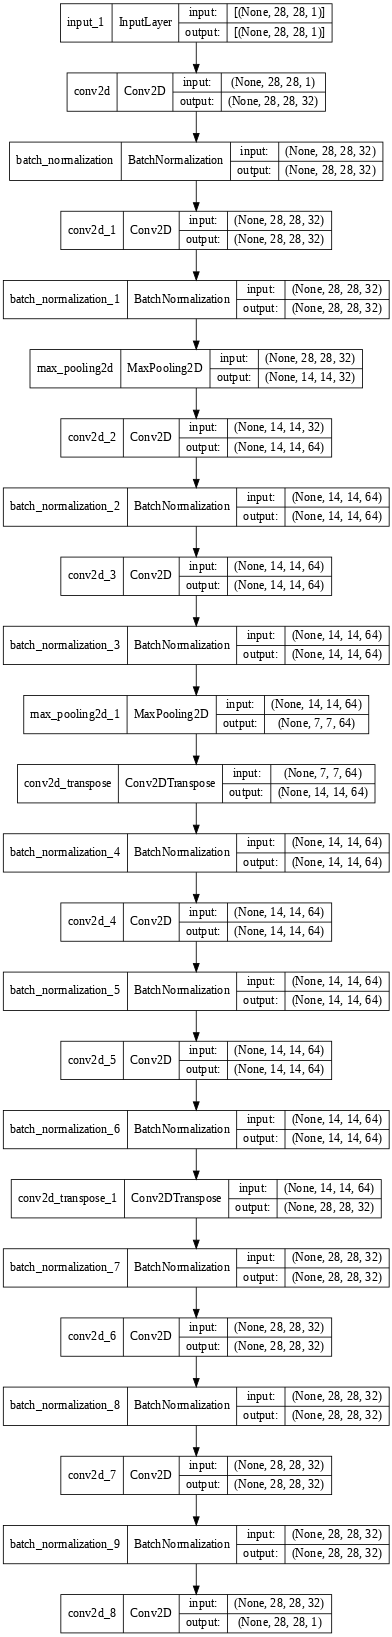

In [ ]:
utils.plot_model(modelAutoMnist, dpi=60, show_shapes=True)

In [ ]:
#Обучаем модель автокодировщика
history = modelAutoMnist.fit(xTrainMnist, 
                             xTrainMnist, 
                             epochs=100, 
                             batch_size=256, 
                             validation_data = (xTestMnist, xTestMnist))

Epoch 1/100
235/235 [==============================] - 6s 27ms/step - loss: 0.0139 - val_loss: 0.0135
Epoch 2/100
235/235 [==============================] - 6s 27ms/step - loss: 0.0083 - val_loss: 0.0067
Epoch 3/100
235/235 [==============================] - 6s 27ms/step - loss: 0.0061 - val_loss: 0.0055
Epoch 4/100
235/235 [==============================] - 6s 27ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 5/100
235/235 [==============================] - 6s 27ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/100
235/235 [==============================] - 6s 27ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 7/100
235/235 [==============================] - 6s 27ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 8/100
235/235 [==============================] - 6s 27ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 9/100
235/235 [==============================] - 6s 27ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 10/100
235/235 [==============================] - 6s 27ms/step - loss: 0.002

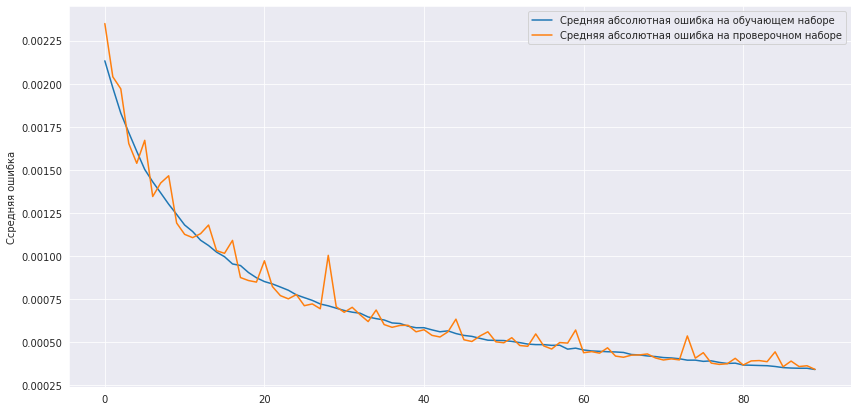

In [ ]:
# Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'][10:],
         label = 'Cредняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'][10:],
         label = 'Cредняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Cсредняя ошибка')
plt.legend()
plt.show()

In [ ]:
modelAutoMnist.save_weights('/content/drive/MyDrive/Colab Notebooks/Базы/modelAutoMnist.h5')
modelAutoMnist.load_weights('/content/drive/MyDrive/Colab Notebooks/Базы/modelAutoMnist.h5')

In [ ]:
predMnistTest = modelAutoMnist.predict(xTestMnist) # предиктим тестовые данные нашей моделью
predMnistTest = predMnistTest * 255 # возвращаем исходные параметры значениям от 0 до 255
predMnistTest = predMnistTest.astype('uint8') # устанавливаем 8 битовый тип


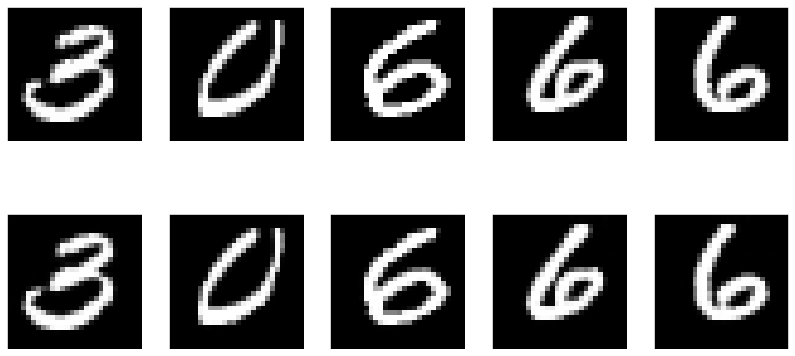

In [ ]:
# Покажем исходные данные и восстановленные 
plotImages(xTestMnist, predMnistTest, shape=(28,28)) 

In [ ]:
predMnistTrain = modelAutoMnist.predict(xTrainMnist) # получаем результат работы модели на обучающем наборе 
predMnistTrain = predMnistTrain * 255 # представляем в виде значений от 0 до 255
predMnistTrain = predMnistTrain.astype('uint8') # устанавливаем 8 битовый тип


In [ ]:
err1 = [getMSE(xTrainMnist[i], predMnistTrain[i] / 255) for i in range(len(predMnistTrain))]# Возьмем среднеквадратичную ошибку от правильной картинки и восстановленной (обучающая выборка)
err2 = [getMSE(xTestMnist[i], predMnistTest[i] / 255) for i in range(len(predMnistTest))]# Возьмем среднеквадратичную ошибку от правильной картинки и восстановленной (тестовая выборка)
print('Средняя ошибка на обучающем наборе MNIST ', sum(err1) / xTrainMnist.shape[0]) # Отобразим ошибку на обучающей выборке
print('Средняя ошибка на тестовом наборе MNIST ', sum(err2) /xTestMnist.shape[0] ) # Отобразим ошибку на тестовой выборке

Средняя ошибка на обучающем наборе MNIST  [[8.35502829e-07 8.35502829e-07 8.35502829e-07 ... 8.35502829e-07
  8.35502829e-07 8.35502829e-07]
 [2.40038172e-05 2.40038172e-05 2.40038172e-05 ... 2.40038172e-05
  2.40038172e-05 2.40038172e-05]
 [3.78299070e-04 3.78299070e-04 3.78299070e-04 ... 3.78299070e-04
  3.78299070e-04 3.78299070e-04]
 ...
 [2.07359369e-03 2.07359369e-03 2.07359369e-03 ... 2.07359369e-03
  2.07359369e-03 2.07359369e-03]
 [3.09677752e-04 3.09677752e-04 3.09677752e-04 ... 3.09677752e-04
  3.09677752e-04 3.09677752e-04]
 [6.50447630e-06 6.50447630e-06 6.50447630e-06 ... 6.50447630e-06
  6.50447630e-06 6.50447630e-06]]
Средняя ошибка на тестовом наборе MNIST  [[7.73109244e-07 7.73109244e-07 7.73109244e-07 ... 7.73109244e-07
  7.73109244e-07 7.73109244e-07]
 [3.00337782e-05 3.00337782e-05 3.00337782e-05 ... 3.00337782e-05
  3.00337782e-05 3.00337782e-05]
 [3.49445158e-04 3.49445158e-04 3.49445158e-04 ... 3.49445158e-04
  3.49445158e-04 3.49445158e-04]
 ...
 [1.97203306e-0